<a href="https://colab.research.google.com/github/mtofighi/Machine-Learning-Model-Interpretation/blob/master/MachineLearningModelInterpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608

# **Loading Necessary Dependencies**
We will be using a lot of frameworks and tools in this article given it is a hands-on guide to model interpretation. We recommend you to load up the following dependencies to get the maximum out of this guide!

In [0]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

![alt text](https://miro.medium.com/max/1667/1*oYNSWK4pccDUYzh-DBdA5g.png)

In [2]:
pip install shap

In [3]:
pip install eli5

Rememeber to call the shap.initjs() function since a lot of the plots from shap require JavaScript.

In [4]:
import pandas as pd
import numpy as np
#import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Using TensorFlow backend.


# **Load and View the Census Income Dataset**
You can actually get the census income dataset (popularly known as the adult dataset) from the UCI ML repository. Fortunately shap provides us an already cleaned up version of this dataset which we will be using here since the intent of this article is model interpretation.
## **Viewing the Data Attributes**
Let’s take a look at the major features or attributes of our dataset.

In [35]:
data, labels = shap.datasets.adult(display=True)
print(labels)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
print(labels)
data.head()

[False False False ... False False  True]
(32561, 12) (32561,)
[0 0 0 ... 0 0 1]


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


**Viewing the Class Labels**

Let’s view the distribution of people with <= $50K (False) and > $50K (True) income which are our class labels which we want to predict.

In [6]:
Counter(labels)

Counter({0: 24720, 1: 7841})

Definitely some class imbalance which is expected given that we should have less people having a higher income.
# **Understanding the Census Income Dataset**
Let’s now take a look at our dataset attributes and understand their meaning and significance.

| Attribute Name 	| Type 	| Description 	|
|-----------------------	|----------------------------	|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Age 	| Continuous 	| Represents age of the person 	|
| Workclass 	| Categorical 	| Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) 	|
| Education-Num 	| Categorical 	| Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) 	|
| Marital Status 	| Categorical 	| Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) 	|
| Occupation 	| Categorical 	| Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) 	|
| Relationship 	| Categorical 	| Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) 	|
| Race 	| Categorical 	| Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) 	|
| Sex 	| Categorical 	| Represents the gender of the person<br>(Female, Male) 	|
| Capital Gain 	| Continuous 	| The total capital gain for the person 	|
| Capital Loss 	| Continuous 	| The total capital loss for the person 	|
| Hours per week 	| Continuous 	| Total hours spent working per week 	|
| Country 	| Categorical 	| The country where the person is residing 	|
| Income Label (labels) 	| Categorical  (class label) 	| The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) 	|

We have a total of 12 features and our objective is to predict if the income of a person will be more than $50K (True) or less than $50K (False). Hence we will be building and interpreting a classification model.

# **Basic Feature Engineering**
Here we convert the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don’t one-hot encode the features here.

In [7]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


Time to build our train and test datasets before we build our classification model.

# **Building Train and Test Datasets**
For any machine learning model, we always need train and test datasets. We will be building the model on the train dataset and test the performance on the test dataset. We maintain two datasets (one with the encoded categorical values and one with the original values) so we can train with the encoded dataset but use the original dataset as needed later on for model interpretation.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,6,9.0,2,5,5,4,0,0.0,2179.0,12.0,39
1216,48.0,6,10.0,2,3,0,0,1,7688.0,0.0,40.0,39
27962,23.0,7,10.0,2,10,0,4,1,0.0,0.0,30.0,39


We also maintain our base dataset with the actual (not encoded) values also in a separate dataframe (useful for model interpretation later).

In [9]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,Self-emp-not-inc,9.0,Married-civ-spouse,Farming-fishing,Wife,White,Female,0.0,2179.0,12.0,United-States
1216,48.0,Self-emp-not-inc,10.0,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40.0,United-States
27962,23.0,State-gov,10.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States


# **Training the classification model**
We will now train and build a basic boosting classification model on our training data using the popular XGBoost framework, an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.


In [10]:
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 7.95 s, sys: 18.4 ms, total: 7.97 s
Wall time: 7.98 s


# **Making predictions on the test data**
Here we do the usual, use the trained model to make predictions on the test dataset.

In [11]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

# **Model Performance Evaluation**
Time to put the model to the test! Let’s evaluate how our model has performed with its predictions on the test data. We use my nifty model_evaluation_utils module for this which leverages scikit-learn internally to give us standard classification model evaluation metrics.

In [12]:
# class_labels = list(set(labels))
# meu.display_model_performance_metrics(true_labels=y_test, 
#                                       predicted_labels=predictions, 
#                                       classes=class_labels)

NameError: ignored

# **Default Model Interpretation Methods**
By default it is difficult to gauge on specific model interpretation methods for machine learning models out of the box. Parametric models like logistic regression are easier to interpret given that the total number of parameters of the model are fixed regardless of the volume of data and one can make some interpretation of the model’s prediction decisions leveraging the parameter coefficients.
Non-parametric models are harder to interpret given that the total number of parameters remain unbounded and increase with the increase in the data volume. Some non-parametric models like tree-based models do have some out of the box model interpretation methods like feature importance which helps us in understanding which features might be influential in the model making its prediction decisions.
Classic feature importances from XGBoost
Here we try out the global feature importance calcuations that come with XGBoost. The model enables us to view feature importances based on the following.
Feature Weights: This is based on the number of times a feature appears in a tree across the ensemble of trees
Gain: This is based on the average gain of splits which use the feature
Coverage: This is based on the average coverage (number of samples affected) of splits which use the feature
Note that they all contradict each other, which motivates the use of model interpretation frameworks like SHAP which uses something known as SHAP values, which claim to come with consistency guarantees (meaning they will typically order the features correctly).


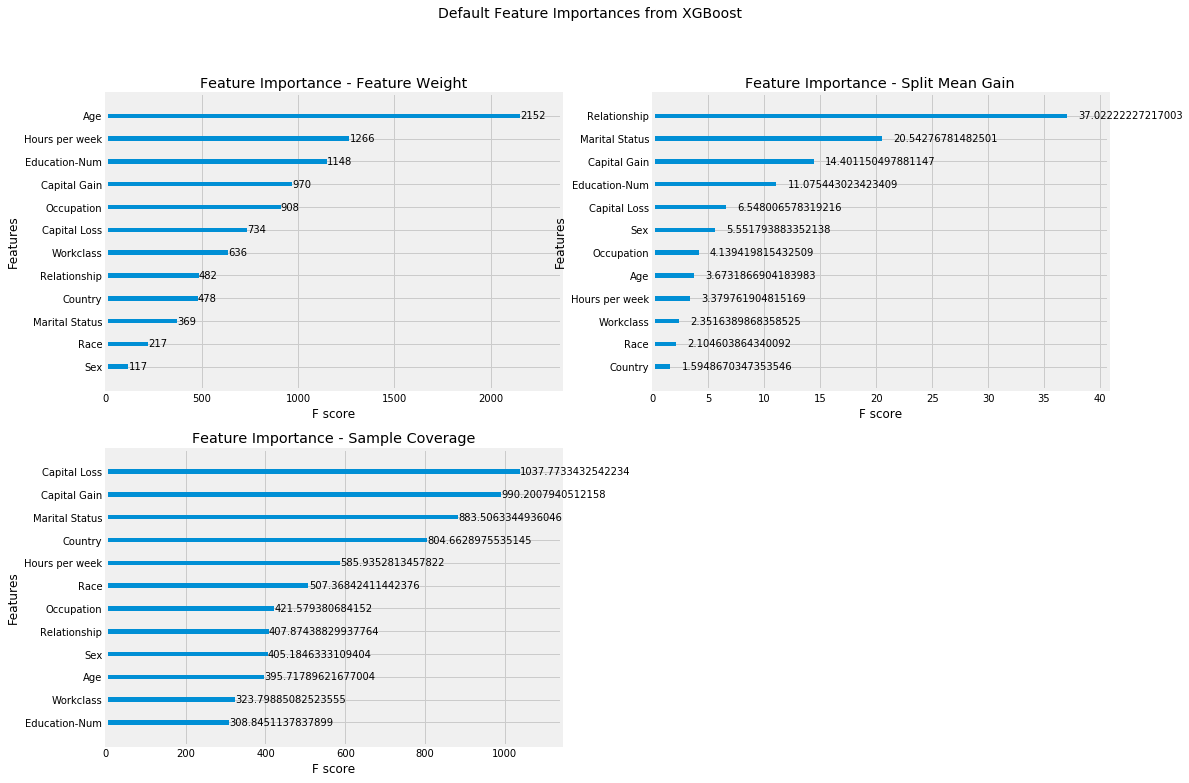

In [13]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

# **Model Interpretation with ELI5**
ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions in an easy to understand an intuitive way. It is perhaps the easiest of the three machine learning frameworks to get started with since it involves minimal reading of documentation! However it doesn’t support true model-agnostic interpretations and support for models are mostly limited to tree-based and other parametric\linear models. Let’s look at some intuitive ways of model interpretation with ELI5 on our classification model.
# **Installation Instructions**
We recommend installing this framework using pip install eli5 since the conda version appears to be a bit out-dated. Also feel free to check out the documentation as needed.
Feature Importances with ELI5
Typically for tree-based models ELI5 does nothing special but uses the out-of-the-box feature importance computation methods which we discussed in the previous section. By default, ‘gain’ is used, that is the average gain of the feature when it is used in trees.

In [14]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.3294,Relationship
0.1828,Marital Status
0.1281,Capital Gain
0.0985,Education-Num
0.0583,Capital Loss
0.0494,Sex
0.0368,Occupation
0.0327,Age
0.0301,Hours per week
0.0209,Workclass


# **Explaining Model Prediction Decisions with ELI5**
One of the best way to explain model prediction decisions to either a technical or a more business-oriented individual, is to examine individual data-point predictions. Typically, ELI5 does this by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across all trees. The idea for weight calculation is described here; ELI5 provides an independent implementation of this algorithm for XGBoost and most scikit-learn tree ensembles which is definitely on the path towards model-agnostic interpretation but not purely model-agnostic like LIME.
Typically, the prediction can be defined as the sum of the feature contributions + the “bias” (i.e. the mean given by the topmost region that covers the entire training set)

**Predicting when a person’s income <= $50K**

Here we can see the most influential features being the Age, Hours per week, Marital Status, Occupation & Relationship


In [15]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns),
                     show_feature_values=True)

Actual Label: 0
Predicted Label: 0


**Predicting when a person’s income > $50K**

Here we can see the most influential features being the Education, Relationship, Occupation, Hours per week & Marital Status

In [16]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns), 
                     show_feature_values=True)

Actual Label: 1
Predicted Label: 1


# **Global Interpretations with Skater**
A predictive model is a mapping from an input space to an output space. Interpretation algorithms are divided into those that offer statistics and metrics on regions of the domain, such as the marginal distribution of a feature, or the joint distribution of the entire training set. In an ideal world there would exist some representation that would allow a human to interpret a decision function in any number of dimensions. Given that we generally can only intuit visualizations of a few dimensions at time, global interpretation algorithms either aggregate or subset the feature space.
Currently, model-agnostic global interpretation algorithms supported by skater include partial dependence and feature importance with a very new release of tree-surrogates also. We will be covering feature importance and partial dependence plots here.

In [17]:
pip install skater

In [0]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_test, training_labels=y_test, 
                             feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
                         target_names=['$50K or less', 'More than $50K'])

# **Feature Importances with Skater**

Feature importance is generic term for the degree to which a predictive model relies on a particular feature. The skater feature importance implementation is based on an information theoretic criteria, measuring the entropy in the change of predictions, given a perturbation of a given feature. The intuition is that the more a model’s decision criteria depend on a feature, the more we’ll see predictions change as a function of perturbing a feature. The default method used is prediction-variance which is the mean absolute value of changes in predictions, given perturbations in the data.

2019-11-26 22:52:13,208 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 12 seconds

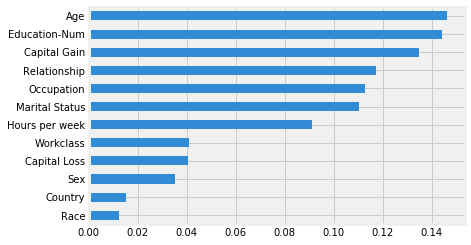

In [19]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, 
                                                               n_samples=23000)

**Partial Dependence**

Partial Dependence describes the marginal impact of a feature on model prediction, holding other features in the model constant. The derivative of partial dependence describes the impact of a feature (analogous to a feature coefficient in a regression model). This has been adapted from T. Hastie, R. Tibshirani and J. Friedman, Elements of Statistical Learning Ed. 2, Springer. 2009.
The partial dependence plot (PDP or PD plot) shows the marginal effect of a feature on the predicted outcome of a previously fit model. PDPs can show if the relationship between the target and a feature is linear, monotonic or more complex. Skater can show 1-D as well as 2-D PDPs
PDP of ‘Age’ affecting model prediction
Let’s take a look at how the Age feature affects model predictions.

2019-11-26 22:54:05,577 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 37 seconds

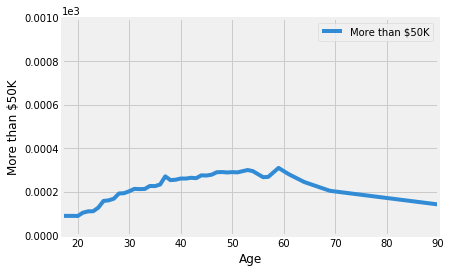

In [20]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

Looks like the middle-aged people have a slightly higher chance of making more money as compared to younger or older people.

PDP of ‘Education Num’ affecting model prediction
Let’s take a look at how the Education-Num feature affects model predictions.

2019-11-26 22:56:40,267 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 13 seconds

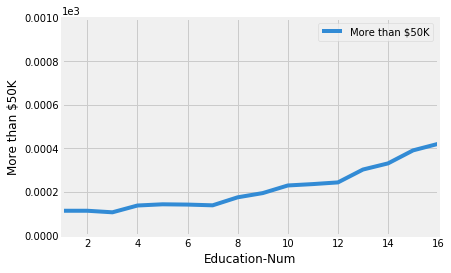

In [21]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

Looks like higher the education level, the better the chance of making more money. Not surprising!

PDP of ‘Capital Gain’ affecting model prediction
Let’s take a look at how the Capital Gain feature affects model predictions.

2019-11-26 22:58:13,220 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 5 seconds

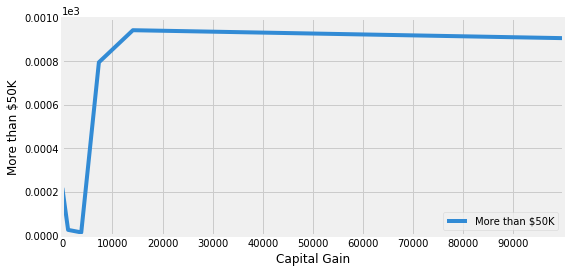

In [22]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (8, 4), n_samples=23000)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

Unsurprisingly higher the capital gain, the more chance of making money, there is a steep rise in around $5K — $8K.

PDP of ‘Relationship’ affecting model prediction
Remember that relationship is coded as a categorical variable with numeric representations. Let’s first look at how it is represented.

In [23]:
pd.concat([data_disp[['Relationship']], data[['Relationship']]], 
          axis=1).drop_duplicates()

,Relationship,Relationship
0,Not-in-family,1
1,Husband,0
4,Wife,5
12,Own-child,3
17,Unmarried,4
74,Other-relative,2
